    LinkedIn jobs analysis with Spacy

In [232]:
import pandas as pd
import numpy as np
import json

import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English

#Visualization
import matplotlib.pyplot as plt
from spacy import displacy
import plotly
import plotly.express as px
import plotly.graph_objects as go
import colorlover as cl
from wordcloud import WordCloud

import warnings 
warnings.filterwarnings('ignore')

In [233]:
jobs_df = pd.read_json("../data/linkedin_jobs_scraped.json", convert_dates=['posted_date','scraping_date'])
jobs_df.head()

,Job_ID,Job_txt,company,job-title,level,location,posted-time-ago,nb_candidats,scraping_date,posted_date,skills
0,4137245989,"Junior Software Developer IBM Sofia, Sofia Cit...",IBM,Junior Software Developer,Entry level,"Sofia, Sofia City, Bulgaria",1 week ago,41.0,2025-02-06,2025-01-30,"[computer science, support, engineering, data ..."
1,3936580453,"Junior Software Engineer Trading 212 Sofia, So...",Trading 212,Junior Software Engineer,Entry level,"Sofia, Sofia City, Bulgaria",1 week ago,NaN,2025-02-06,2025-01-30,"[framework, go, database, typescript, release,..."
2,4063857099,"Junior Python Developer DXC Technology Sofia, ...",DXC Technology,Junior Python Developer,Entry level,"Sofia, Sofia City, Bulgaria",3 months ago,NaN,2025-02-06,2024-11-08,"[analytics, snowflake, computer science, suppo..."
3,4122081493,"Junior Java Engineer Dreamix Sofia, Sofia City...",Dreamix,Junior Java Engineer,Entry level,"Sofia, Sofia City, Bulgaria",3 weeks ago,NaN,2025-02-06,2025-01-16,"[computer science, hibernate, software enginee..."
4,4121139946,Junior Backend Developer LimeChain - Blockchai...,LimeChain - Blockchain & Web3 Solutions,Junior Backend Developer,Entry level,Sofia Metropolitan Area,3 weeks ago,174.0,2025-02-06,2025-01-16,"[git, support, framework, code review, go, eng..."


Create a jsonl file containing the skill patterns that can be used to create spaCy entity_ruler

`skills_in_demand.txt`  
A plain text file containing a list of in-demand skills, with each skill written on a new line
It is used for extracting and processing skills in job-related tasks

Can update file with skills from here, based on what we need and what we want to be included

In [234]:
with open("../data/skills_in_demand.txt", 'r', encoding='ISO-8859-1') as file_txt:
    list_skills_in_demand = set(x.strip().lower() for x in file_txt.readlines())  # Using a set to remove duplicates immediately

new_skills_in_demand = ["Glue", "EMR", "AWS services", "AWS Developer", "AWS", "Azure", "Scikit-learn", "Seaborn", "Matplotlib", "Go"]

for new_skill in new_skills_in_demand:
    list_skills_in_demand.add(new_skill.lower())

with open("../data/skills_in_demand.txt", 'w', encoding='ISO-8859-1') as f:
    for skill in sorted(list_skills_in_demand):
        f.write(skill + '\n')

print("New skills added successfully!")

New skills added successfully!


In [235]:
file_txt = open("../data/skills_in_demand.txt", 'r', encoding='ISO-8859-1')
list_skills_in_demand = []
for x in file_txt.readlines():
    list_skills_in_demand.append(x.strip())
file_txt.close()

rule_patterns = []
for skill in list_skills_in_demand:
    pattren = []
    for elt in skill.split(" "):
        pattren.append({"LOWER":elt})
        
    json_data = {"label":"SKILL","pattern":pattren}
    json_string = json.dumps(json_data,ensure_ascii=True)
    rule_patterns.append(json_string)

file_jsonl = open("../data/skill_patterns.jsonl", "w")
for k in range(len(rule_patterns)):
    file_jsonl.write(rule_patterns[k]+"\n")
file_jsonl.close()

print("jsonl file created!")

jsonl file created!


    Loading spaCy model

In [236]:

import spacy
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.5 MB/s eta 0:00:0000:0100:06
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [237]:
nlp = spacy.load("en_core_web_lg")

skill_pattern_path = "../data/skill_patterns.jsonl"

    Create spaCy entity_ruler
To create an entity ruler, need to add a pipeline and then load the .jsonl file containing the skills into the ruler

The entity_ruler is a component in the SpaCy pipeline that can match patterns in the text and assign entity labels to them

In [238]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names  # returns a list of the names of the components currently in the SpaCy pipeline

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [239]:
ruler.patterns[:10]

[{'label': 'SKILL', 'pattern': [{'LOWER': '.net'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': '1password'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': '3d'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': '3d'}, {'LOWER': 'reconstruction'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': 'aboutness'}]},
 {'label': 'SKILL',
  'pattern': [{'LOWER': 'abstract'}, {'LOWER': 'data'}, {'LOWER': 'type'}]},
 {'label': 'SKILL',
  'pattern': [{'LOWER': 'abstract'}, {'LOWER': 'interpretation'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': 'abstract'}, {'LOWER': 'machine'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': 'access'}, {'LOWER': 'control'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': 'access'}, {'LOWER': 'method'}]}]

    Create new feature called 'skills'

In [240]:
def get_skills(text):
    doc = nlp(text)
    list_skills = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            list_skills.append(ent.text.lower())
    return list_skills

def unique_skills(list_skills):
    return list(set(list_skills))

In [241]:
jobs_df["skills"] = jobs_df["Job_txt"].str.lower().apply(get_skills)
jobs_df["skills"] = jobs_df["skills"].apply(unique_skills)

In [242]:
jobs_df.to_json("../data/linkedin_jobs_scraped.json")
jobs_df.head()

,Job_ID,Job_txt,company,job-title,level,location,posted-time-ago,nb_candidats,scraping_date,posted_date,skills
0,4137245989,"Junior Software Developer IBM Sofia, Sofia Cit...",IBM,Junior Software Developer,Entry level,"Sofia, Sofia City, Bulgaria",1 week ago,41.0,2025-02-06,2025-01-30,"[computer science, support, engineering, data ..."
1,3936580453,"Junior Software Engineer Trading 212 Sofia, So...",Trading 212,Junior Software Engineer,Entry level,"Sofia, Sofia City, Bulgaria",1 week ago,NaN,2025-02-06,2025-01-30,"[framework, go, database, typescript, release,..."
2,4063857099,"Junior Python Developer DXC Technology Sofia, ...",DXC Technology,Junior Python Developer,Entry level,"Sofia, Sofia City, Bulgaria",3 months ago,NaN,2025-02-06,2024-11-08,"[analytics, snowflake, computer science, suppo..."
3,4122081493,"Junior Java Engineer Dreamix Sofia, Sofia City...",Dreamix,Junior Java Engineer,Entry level,"Sofia, Sofia City, Bulgaria",3 weeks ago,NaN,2025-02-06,2025-01-16,"[computer science, hibernate, software enginee..."
4,4121139946,Junior Backend Developer LimeChain - Blockchai...,LimeChain - Blockchain & Web3 Solutions,Junior Backend Developer,Entry level,Sofia Metropolitan Area,3 weeks ago,174.0,2025-02-06,2025-01-16,"[git, support, framework, code review, go, eng..."


    Visualization

This code generates a WordCloud that visualizes the most frequently mentioned skills from a dataset of job postings. It uses the WordCloud library to generate the image and Matplotlib to display it

As a result, words that appear more frequently are displayed with larger fonts


Text(0.5, 1.0, 'Skills in demand\n')

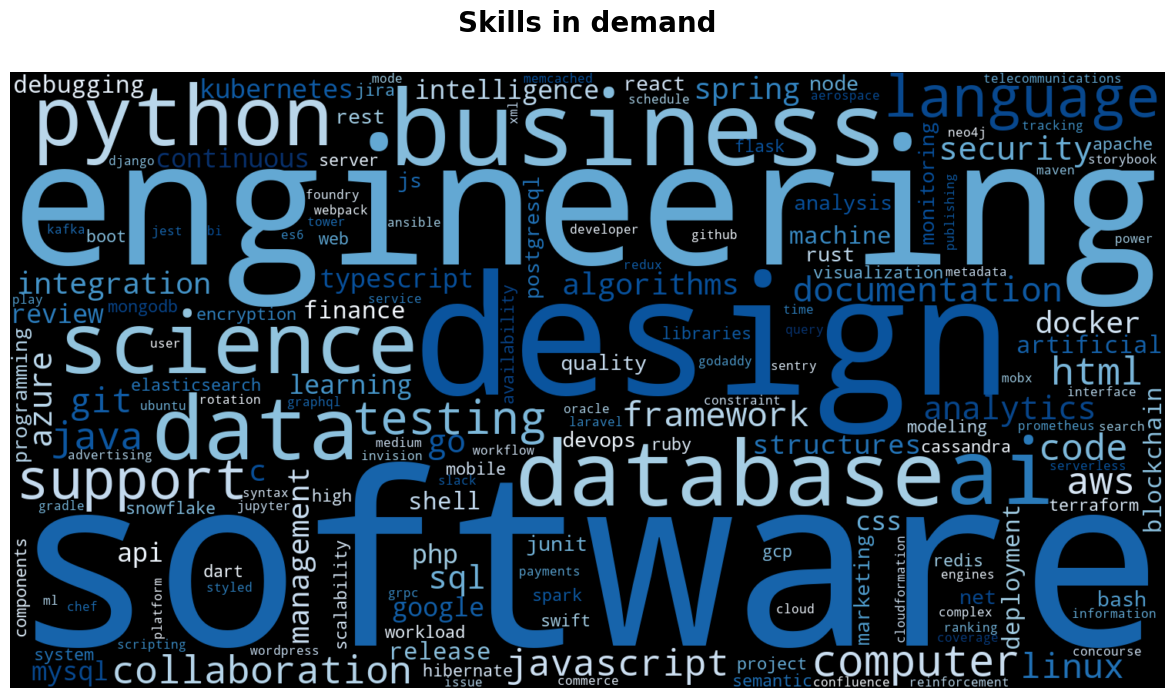

In [243]:
list_skills = []
for skills in jobs_df.skills.values:
    for skill in skills:
        list_skills.append(skill)

# since WordCloud requires a string input, this step joins all skills into one long text
list_skills = " ".join(list_skills)

wordcloud = WordCloud(background_color='black',max_words=200,
                      width=1500,height=800,max_font_size=500,collocations=False) # disables collocations (groups of words that often appear together, like "data science")
wordcloud.generate(list_skills)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear') # ensures a smooth, high-quality display
plt.axis("off")
plt.title(f"Skills in demand\n",size = 20, weight = 'bold')

    Level Distribution (Pie Chart)

This code generates a pie chart using Plotly to visualize the distribution of job levels (e.g., Junior, Senior, etc.) from a dataset of job posting

In [244]:
level_counts = jobs_df.groupby('level').count()['Job_ID'].sort_values(ascending=False)

blue = cl.flipper()['seq']['9']['Blues']
red = cl.flipper()['seq']['9']['Reds']
colors = [blue[5], red[3], blue[3], red[4]]
fig = go.Figure(data=[go.Pie(labels=list(level_counts.index),
                             values=level_counts,hole=0.5,
                             marker={"colors": colors},
                             sort=False,)],
                layout={'title': 'Level Distribution',
                        'showlegend': True,
                        'hoverlabel': dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"),
                        'legend': {'orientation': 'h', 'xanchor': "center", 'x': 0.5, 'y': -0.15}
                      }                    
               )
fig.show()

    Entity Recognition

Using Spacy's Entity Recognition capabilities and displacy.render, we can display different entities within text, e.g. skills, ORGs, GEPs...

The purpose of this part of the code is to extract key pieces of information (like job text, required skills, and missing skills) from a specific job posting in the dataset

In [246]:
job_example = jobs_df.iloc[0]  # get one job posting
job_txt_example = job_example['Job_txt']
required_skills_example = job_example['skills']
missing_skills_example = job_example['missing_skills']

This line uses spaCy's displacy visualization tool to render the named entities recognized in a job description (job_txt_example)

style="ent" -> tells displacy.render() to highlight entities (e.g., skills, locations, organizations) in the text. The entities are colored differently to distinguish them

In [125]:
displacy.render(nlp(job_txt_example), style="ent", jupyter=True)

    Custom Entity Recognition

We can customize our Entity Recognition as follows:

* Add a job level (entry level, mid-senior level...) to the entity ruler
* Add custom colours to all categories

In [247]:
Job_levels = jobs_df.level.unique()
for a in Job_levels:
    print(a)
    ruler.add_patterns([{"label": "Job-level", "pattern": a}])

Entry level
Associate
Not Applicable
Mid-Senior level


In [248]:
colors = {
    "SKILL": "linear-gradient(90deg,#9BE15D, #00E3AE)",    
    "Job-level": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "ORG": "lightgray", # None: for no color
    "PERSON": "#e06666",
    "GPE": "#9fc5e8", # geopolitical entities like cities, countries
    "DATE": "#c27ba0", 
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": ["SKILL",
             "Job-level",
             "ORG",
             "PERSON",
             "GPE",
             "DATE",
             "PRODUCT",
    ],
    "colors": colors,
}

In [249]:
displacy.render(nlp(job_txt_example), style="ent", jupyter=True,options=options)

As we can see, some skills are mapped as ORG (such as Elasticsearch, Nginx, TimescaleDB etc.)

Since the goal is to match and highlight all skills, can reload spacy model and disable the NER entity

In [250]:
nlp_without_NER = spacy.load("en_core_web_lg", disable = ['ner']) 

ruler_without_NER = nlp_without_NER.add_pipe("entity_ruler")
ruler_without_NER.from_disk(skill_pattern_path)

nlp_without_NER.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'entity_ruler']

In [251]:
displacy.render(nlp_without_NER(job_txt_example), style="ent", jupyter=True,options=options)

As we can see, the model has successfully highlighted all the skills required for the job

    Match Score


To find the most relevant job opportunities, this section matches job requirements with available skills.

Skills can be provided in string format or extracted from a resume (PDF format) for analysis.

In [410]:
# format: comma-separated string
skills_from_text = "flask,Scikit-learn,Apache Spark,analytics,support,databases,machine learning,data visualization,\
mysql,data analysis,tensorflow,database,data science,java,python,computer science,snowflake,engineering,information management,docker,linux"

skills_from_text = skills_from_text.lower()
skills_from_text

'flask,scikit-learn,apache spark,analytics,support,databases,machine learning,data visualization,mysql,data analysis,tensorflow,database,data science,java,python,computer science,snowflake,engineering,information management,docker,linux'

In [358]:
from pdf_reader import pdf_miner
resume_txt = pdf_miner("../resume/resume_skills_example.pdf")
 
skils_from_pdf = unique_skills(get_skills(resume_txt))
skils_from_pdf = ",".join(skils_from_pdf)
skils_from_pdf

'machine learning,scikit-learn,data visualization,sql,python'

    Calculate the percentage of match skills

Calculate the percentage of required job skills that match the user's skills

match score = (total job skills / matched skills) × 100

In [353]:
from spacy.matcher import Matcher

def get_match_score(job_skills, your_skills):
    list_your_skills = your_skills.split(",")
    
    score = 0

    for x in job_skills:
        if x in list_your_skills:
            score += 1
    
    job_skills_len = len(job_skills)
    match_score = round(score / job_skills_len * 100, 1) if job_skills_len > 0 else None
    
    return match_score

Function below identifies missing skills by comparing the job's required skills with the user's skills

In [359]:
def get_missing_skills(list_job_skills, str_your_skills, return_list=True):

    list_your_skills = [skill.strip().lower() for skill in str_your_skills.split(",")]
    missing_skills = [x for x in list_job_skills if x.lower() not in list_your_skills]

    return missing_skills if return_list else ", ".join(missing_skills)

In [360]:
jobs_df["match_score"] = np.vectorize(get_match_score)(jobs_df["skills"], skills_from_text)
jobs_df["missing_skills"] = np.vectorize(get_missing_skills)(jobs_df["skills"], skills_from_text, return_list=False)
jobs_df = jobs_df.sort_values(by="match_score", ascending=False)

In [361]:
jobs_df[jobs_df.level=="Entry level"].head(5)

,Job_ID,Job_txt,company,job-title,level,location,posted-time-ago,nb_candidats,scraping_date,posted_date,skills,match_score,missing_skills,cosine_match,exact_match,cosine_match_score,exact_match_score
5,4133033481,Junior Data Engineer DXC Technology Bulgaria 2...,DXC Technology,Junior Data Engineer,Entry level,Bulgaria,2 weeks ago,NaN,2025-02-06,2025-01-23,"[analytics, snowflake, computer science, engin...",63.6,"languages, azure, sql, business",0,1,0.0,72.7
2,4063857099,"Junior Python Developer DXC Technology Sofia, ...",DXC Technology,Junior Python Developer,Entry level,"Sofia, Sofia City, Bulgaria",3 months ago,NaN,2025-02-06,2024-11-08,"[analytics, snowflake, computer science, suppo...",53.3,"software, design, azure, payments, devops, col...",0,0,0.0,46.7
27,3787789000,Junior SAP ABAP Developer Qinlox Consulting So...,Qinlox Consulting,Junior SAP ABAP Developer,Entry level,"Sofia, Sofia City, Bulgaria",1 year ago,NaN,2025-02-06,2024-02-07,"[support, engineering, publishing, software, b...",40.0,"publishing, software, business",0,1,0.0,60.0
10,4121134848,Graduate/Associate Software Engineer - Build &...,Canonical,Graduate/Associate Software Engineer - Build &...,Entry level,"Sofia, Sofia City, Bulgaria",3 weeks ago,NaN,2025-02-06,2025-01-16,"[computer science, security, engineering, data...",37.5,"security, software, design, release, data mana...",0,0,0.0,31.2
13,4129433849,"Junior BI Developer DSK Bank Sofia, Sofia City...",DSK Bank,Junior BI Developer,Entry level,"Sofia, Sofia City, Bulgaria",2 weeks ago,NaN,2025-02-06,2025-01-23,"[computer science, visualization, power bi, da...",35.7,"visualization, power bi, business intelligence...",0,0,0.0,42.9


    Highlighting Job Skills Based on Candidate Profile

The job description is displayed with highlighted skills to indicate those that match the candidate's profile and those that are missing

Previously, SpaCy was used to extract and highlight all required job skills using displacy.render()

Now, a function is introduced to:

- Highlight skills present in the candidate’s profile 
- Highlight skills not found in the candidate’s profile 

    spacy.matcher.Matcher

In [258]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

pattern1 = [{'LOWER': 'data'},{'LOWER': 'base'}] # consecutive words
pattern2 = [{'LOWER': 'junior'}] # the lowercase form of the token text.
pattern3 = [{'LOWER': 'sql'}]
pattern4 = [{'LOWER': 'software'},{'LOWER': 'engineering'}] # consecutive words

matcher.add('rule_1', [pattern1])
matcher.add('rule_2', [pattern2])
matcher.add('rule_3', [pattern3])
matcher.add('rule_3', [pattern4])

doc_example = nlp_without_NER(job_txt_example)
list_matches = matcher(doc_example)
print("list_matches:",list_matches)

# print([token.text for token in doc_example])


list_matches: [(375134486054924901, 0, 1), (375134486054924901, 38, 39), (1637373529202695861, 345, 347)]


list_matches contains list of all matches

In [259]:
for match_id, start, end in list_matches: # start, end are the positions of the matched toknes in the nlp(doc)
    matched_span = doc_example[start:end]
    print("matched_span:","'"+matched_span.text+"'",". (start_index, end_index):",(start,end))

matched_span: 'Junior' . (start_index, end_index): (0, 1)
matched_span: 'Junior' . (start_index, end_index): (38, 39)
matched_span: 'Software Engineering' . (start_index, end_index): (345, 347)


      Highlighting Skills Present and Missing
   
Create functions to visually highlight the skills that are present in the skill set, as well as those that are missing, within the job description.

Function designed to generate a pattern that can be used for rule-based matching in spaCy. It takes a skill (a string) as input and creates a pattern that matches the skill based on spaCy's rule-based matching system

In [260]:
def get_pattern(skill, rule_based_matching="LOWER"):
    # example: 'data science' --> ['data', 'science']
    skill_split = skill.split()  
    pattern = []
    for obj in skill_split:
        pattern.append({rule_based_matching: obj})
    return pattern

In [261]:
def get_matchers(list_skills, missing_skills, spacy_nlp):
    list_missing_skills = missing_skills
    matcher_OK = Matcher(spacy_nlp.vocab)  # you have this skill
    matcher_NOK = Matcher(spacy_nlp.vocab)  # you do not have this skill
    
    for k, skill in enumerate(list_skills):
        # print(k, skill)
        pattern = get_pattern(skill)
        # print(k, pattern)

        if skill in list_missing_skills:
            matcher_NOK.add(f"rule_{k}", [pattern])
        else:
            matcher_OK.add(f"rule_{k}", [pattern])

    return matcher_OK, matcher_NOK

In [262]:
def get_indexes(list_matches):
    list_indexes = []
    for match in list_matches:
        start_index = match[1]
        end_index = match[2]
        for k in range(start_index, end_index):
            list_indexes.append(k)
    return list_indexes

In [263]:
def return_words_types(job_txt, list_required_skills, list_missing_skills, spacy_nlp):
    """Returns two lists:
    - list of words
    - list of the corresponding types (skill, missing skill, other words)"""

    job_doc_nlp = spacy_nlp(job_txt)

    matcher_OK, matcher_NOK = get_matchers(
        list_required_skills, list_missing_skills, spacy_nlp
    )

    list_matches_OK = matcher_OK(job_doc_nlp)
    list_matches_NOK = matcher_NOK(job_doc_nlp)

    indexes_SKILLS_OK = get_indexes(list_matches_OK)
    indexes_SKILLS_NOK = get_indexes(list_matches_NOK)

    # Get index of other words (not Skills)
    indexes_others = []

    for k, word in enumerate(job_doc_nlp):
        if (k in indexes_SKILLS_OK) | (k in indexes_SKILLS_NOK):
            pass
        else:
            indexes_others.append(k)

    words = []
    types = []

    for k, word in enumerate(job_doc_nlp):
            words.append(word)
            if k in indexes_SKILLS_NOK:
                types.append("SKILL-missing")
            elif k in indexes_SKILLS_OK:
                types.append("SKILL")
            else:
                types.append("other")

    return words, types

In [180]:
words, types = return_words_types(job_txt_example, required_skills_example, missing_skills_example, nlp_without_NER)
# print(required_skills_example)

# print(missing_skills_example)

for index,type in enumerate(types):
    if type!="other":
        print(index,words[index],":",type)

94 business : SKILL
192 Python : SKILL
194 SQL : SKILL-missing
226 Analytics : SKILL
228 Engineering : SKILL
274 Analytics : SKILL
278 Engineering : SKILL
344 Apache : SKILL
345 Spark : SKILL
354 Azure : SKILL-missing
357 Snowflake : SKILL
397 Computer : SKILL
398 science : SKILL
412 Python : SKILL
414 SQL : SKILL-missing
459 Azure : SKILL-missing
467 Snowflake : SKILL
469 MySQL : SKILL-missing
470 Languages : SKILL-missing
491 Engineering : SKILL


        
    These functions will be integrated into the Flask application to highlight the skills that the candidate possesses and those that are missing

    Matching score with cosine similarity

In [401]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_match_score_with_cosine(job_skills, user_skills, vectorizer=None):
    if isinstance(job_skills, list):
        job_skills = " ".join(job_skills)  # Convert list to space-separated string

    job_skills = job_skills.lower().strip()
    user_skills = user_skills.lower().strip()

    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        vectorizer.fit([job_skills, user_skills])

    tfidf_matrix = vectorizer.transform([job_skills, user_skills])
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])

    return cosine_sim[0][0] 




    Precision, Recall, and F1-Score

- Precision tells you how many of the exact matches you predicted were actually correct
- Recall tells you how many of the true matches you were able to correctly identify using the exact match method
- F1-Score provides a balance between Precision and Recall

In [419]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Fit TF-IDF vectorizer
all_skills = jobs_df["skills"].apply(lambda x: " ".join(x)).tolist() + [skills_from_text]
vectorizer = TfidfVectorizer().fit(all_skills)

jobs_df["cosine_match_score"] = jobs_df["skills"].apply(
    lambda x: get_match_score_with_cosine(x, skills_from_text, vectorizer)
)

# Convert scores to binary classification (1 = match, 0 = no match)
jobs_df["cosine_match"] = jobs_df["cosine_match_score"].apply(lambda x: 1 if x >= 0.5 else 0)
jobs_df["exact_match"] = jobs_df["match_score"].apply(lambda x: 1 if x >= 50 else 0)

y_true = jobs_df["exact_match"]
y_pred = jobs_df["cosine_match"]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.2500
Recall: 1.0000
F1-Score: 0.4000
